In [1]:
import gspread
from oauth2client.service_account import ServiceAccountCredentials
from keras.models import Model
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import pickle
import keras
import tensorflow as tf
from keras import backend as K
import sys
import os
import time
sys.path.append(os.path.abspath('../'))
import helpers
from helpers.data_generator import process_data, AutoEncoderDataGenerator, DataGenerator
from helpers.custom_losses import normed_mse, mean_diff_sum_2, max_diff_sum_2, mean_diff2_sum2, max_diff2_sum2

import copy
from helpers.normalization import normalize, denormalize, renormalize
import scipy
from tqdm import tqdm

Using TensorFlow backend.
/home/wconlin/.conda/envs/tfgpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:458: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/wconlin/.conda/envs/tfgpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:459: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/wconlin/.conda/envs/tfgpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:460: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/wconlin/.conda/envs/tfg

In [2]:
matplotlib_colors = [(0.1215, 0.4667, 0.7058), # blue
                     (1.0000, 0.4980, 0.0549), # orange
                     (0.1725, 0.6275, 0.1725), # green
                     (0.8392, 0.1529, 0.1568), # red
                     (0.5804, 0.4039, 0.7412), # violet
                     (0.4980, 0.4980, 0.4980), # grey
                     (0.0902, 0.7450, 0.8117)] # cyan

matlab_colors=[(0.0000, 0.4470, 0.7410), # blue
               (0.8500, 0.3250, 0.0980), # reddish orange
               (0.9290, 0.6940, 0.1250), # yellow
               (0.4940, 0.1840, 0.5560), # purple
               (0.4660, 0.6740, 0.1880), # light green
               (0.3010, 0.7450, 0.9330), # cyan
               (0.6350, 0.0780, 0.1840)] # dark red

colorblind_colors = [(0.0000, 0.4500, 0.7000), # blue
                     (0.8359, 0.3682, 0.0000), # vermillion
                     (0.0000, 0.6000, 0.5000), # bluish green
                     (0.9500, 0.9000, 0.2500), # yellow
                     (0.3500, 0.7000, 0.9000), # sky blue
                     (0.8000, 0.6000, 0.7000), # reddish purple
                     (0.9000, 0.6000, 0.0000)] # orange

dashes = [(1.0, 0.0, 0.0, 0.0, 0.0, 0.0), # solid
          (3.7, 1.6, 0.0, 0.0, 0.0, 0.0), # dashed
          (1.0, 1.6, 0.0, 0.0, 0.0, 0.0), # dotted
          (6.4, 1.6, 1.0, 1.6, 0.0, 0.0), # dot dash
          (3.0, 1.6, 1.0, 1.6, 1.0, 1.6), # dot dot dash
          (6.0, 4.0, 0.0, 0.0, 0.0, 0.0), # long dash
          (1.0, 1.6, 3.0, 1.6, 3.0, 1.6)] # dash dash dot

from matplotlib import rcParams, cycler
matplotlib.rcdefaults()
rcParams['font.family'] = 'DejaVu Serif'
rcParams['mathtext.fontset'] = 'cm'
rcParams['font.size'] = 12
rcParams['figure.facecolor'] = (1,1,1,1)
rcParams['figure.figsize'] = (16,8)
rcParams['figure.dpi'] = 96
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['axes.labelsize'] =  'large'
rcParams['axes.titlesize'] = 'x-large'
rcParams['lines.linewidth'] = 2.5
rcParams['lines.solid_capstyle'] = 'round'
rcParams['lines.dash_capstyle'] = 'round'
rcParams['lines.dash_joinstyle'] = 'round'
rcParams['xtick.labelsize'] = 'large'
rcParams['ytick.labelsize'] = 'large'

color_cycle = cycler(color=colorblind_colors)
dash_cycle = cycler(dashes=dashes)
rcParams['axes.prop_cycle'] =  color_cycle

# Writing to sheets

In [21]:
import gspread
from oauth2client.service_account import ServiceAccountCredentials
import os

base_sheet_path = "https://docs.google.com/spreadsheets/d/10ImJmFpVGYwE-3AsJxiqt0SyTDBCimcOh35au6qsh_k/edit#gid=0"
scope = ['https://spreadsheets.google.com/feeds',
         'https://www.googleapis.com/auth/drive']
creds = ServiceAccountCredentials.from_json_keyfile_name(os.path.expanduser('~/plasma-profile-predictor/drive-credentials.json'), scope)
client = gspread.authorize(creds)
sheet = client.open_by_url(base_sheet_path).sheet1

In [22]:
eq_sigs = {'temp':'etemp',
         'thomson_temp_EFITRT1':'etemp',
         'thomson_temp_EFITRT2':'etemp',
         'dens':'edens',
         'thomson_dens_EFITRT1':'edens',
         'thomson_dens_EFITRT2':'edens',
         'itemp':'itemp',
         'cerquick_temp_EFITRT1':'itemp',
         'cerquick_temp_EFITRT2':'itemp',
         'rotation':'rotation',
         'cerquick_rotation_EFITRT1':'rotation',
         'cerquick_rotation_EFITRT2':'rotation',
         'press_EFITRT1':'press',
         'press_EFITRT2':'press',
         'press_EFIT01':'press',
         'press_EFIT02':'press',
         'ffprime_EFITRT1':'ffprime',
         'ffprime_EFITRT2':'ffprime',
         'ffprime_EFIT01':'ffprime',
         'ffprime_EFIT02':'ffprime',
         'q':'q',
         'q_EFITRT1':'q',
         'q_EFITRT2':'q',
         'q_EFIT01':'q',
         'q_EFIT02':'q'}

metric_names = ['mean_squared_error',
                'mean_absolute_error',
                'median_squared_error',
                'median_absolute_error',
                'percentile25_squared_error',
                'percentile75_squared_error',
                'percentile25_absolute_error',
                'percentile75_absolute_error',
                'percent_correct_sign',
                'baseline_MAE',
                'normed_mse',
                'mean_diff_sum_2',
                'max_diff_sum_2',
                'mean_diff2_sum2',
                'max_diff2_sum2']

eq_metrics = {}
for key,val in eq_sigs.items():
    for metric in metric_names:
        eq_metrics['target_' + key + '_' + metric] = val + '_' + metric
        eq_metrics[key + '_' + metric] = val + '_' + metric
for name in metric_names:
    eq_metrics[name] = name
        
eqinv = {}
for key,val in eq_sigs.items():
    if val in eqinv.keys():
        eqinv[val].append(key)
    else:
        eqinv[val] = [key]

In [23]:
def write_scenario_to_sheets(scenario,sheet):
    """writes a scenario to google sheets"""

    sheet_keys = sheet.row_values(1)
    row = [None]*len(sheet_keys)
    
    for i,key in enumerate(sheet_keys):
        if key in scenario.keys():
            row[i] = str(scenario[key])
        elif key in scenario.get('history',{}):
            row[i] = str(scenario['history'][key][-1])
    
        eval_metrics = scenario.get('evaluation_metrics',{})
        for eval_key in eval_metrics.keys():
            if key == eq_metrics.get(eval_key,None) and key not in ['loss','val_loss']:
                row[i] = str(scenario['evaluation_metrics'][eval_key])
    
    sheet.append_row(row)

In [24]:
import pickle
import time
import helpers
from helpers.data_generator import process_data, AutoEncoderDataGenerator, DataGenerator
from helpers.custom_losses import normed_mse, mean_diff_sum_2, max_diff_sum_2, mean_diff2_sum2, max_diff2_sum2

# base_path = os.path.expanduser('/projects/EKOLEMEN/profile_predictor/run_results_02_22/')
base_path = os.path.expanduser('/projects/EKOLEMEN/profile_predictor/run_results_12_11/')
files = [foo for foo in os.listdir(base_path) if foo.endswith('.h5')]

for i, file in enumerate(files):
    file_path = base_path + file
    file_path = file_path[:-3] + '_params.pkl'
    with open(file_path, 'rb') as f:
        scenario = pickle.load(f, encoding='latin1')
    print('loaded: ' + file)

    if (i+1)%25==0:
        print('pausing for quota bullshit')
        for i in range(100):
            time.sleep(1)
            print(i,end='')
            
    try:

        col = sheet.find('runname').col
        runs = sheet.col_values(col)
        if scenario['runname'] not in runs:
            write_scenario_to_sheets(scenario,sheet)
            print('written')
        else:
            print('already there')
        rowid = sheet.find(scenario['runname']).row
        scenario['sheet_path'] = base_sheet_path + "&range={}:{}".format(rowid,rowid)
        
    except Exception as e: 
        print(e)        


loaded: model-conv2d_profiles-dens-temp-q_EFIT01-rotation-press_EFIT01_act-curr_target-pinj-tinj-target_density-bt_targ-dens-temp-q_EFIT01-rotation-press_EFIT01_profLB-0_actLB-6_ftop-True_12Dec19-20-54_Scenario-60.h5
written
loaded: model-conv2d_profiles-dens-temp-q_EFIT01-rotation-press_EFIT01_act-curr_target-pinj-tinj-target_density-bt_targ-dens-temp-q_EFIT01-rotation-press_EFIT01_profLB-0_actLB-6_ftop-True_15Dec19-00-38_Scenario-172.h5
written
loaded: model-conv2d_profiles-dens-temp-q_EFIT02-rotation-press_EFIT02_act-curr_target-pinj-tinj-target_density-bt_targ-dens-temp-q_EFIT02-rotation-press_EFIT02_profLB-0_actLB-6_ftop-True_14Dec19-10-49_Scenario-144.h5
written
loaded: model-conv1d_profiles-dens-temp-q_EFIT02-rotation-press_EFIT02_act-curr_target-pinj-tinj-target_density-bt_targ-dens-temp-q_EFIT02-rotation-press_EFIT02_profLB-0_actLB-6_ftop-True_13Dec19-17-53_Scenario-101.h5
written
loaded: model-conv1d_profiles-dens-temp-q_EFIT01-rotation-press_EFIT01_act-curr_target-pinj-tinj-

In [15]:
scenario

{'model_type': 'conv2d',
 'model_kwargs': {'max_channels': 16},
 'input_profile_names': ['dens', 'temp', 'itemp', 'q', 'rotation'],
 'target_profile_names': ['dens', 'temp', 'itemp', 'q', 'rotation'],
 'sample_weighting': None,
 'scalar_input_names': [],
 'batch_size': 128,
 'process_data': True,
 'predict_deltas': True,
 'epochs': 195,
 'loss_function': 'mse',
 'actuator_names': ['target_density', 'pinj', 'tinj', 'curr_target'],
 'profile_downsample': 2,
 'std_activation': 'relu',
 'hinge_weight': 0,
 'mse_weight_power': 2,
 'mse_weight_edge': 2,
 'mse_power': 2,
 'flattop_only': True,
 'raw_data_path': '/scratch/gpfs/jabbate/full_data/train_data_full.pkl',
 'processed_filename_base': '/scratch/gpfs/jabbate/data_60_ms_randomized_',
 'optimizer': 'adagrad',
 'optimizer_kwargs': {},
 'shuffle_generators': True,
 'pruning_functions': [<function helpers.pruning_functions.remove_nan(data, verbose)>,
  <function helpers.pruning_functions.remove_dudtrip(data, verbose)>,
  <function helpers.p

# Evaluating models

In [49]:
config = tf.ConfigProto(intra_op_parallelism_threads=16,
                            inter_op_parallelism_threads=16,
                            allow_soft_placement=True,
                            device_count={'CPU': 8,
                                          'GPU': 0})
session = tf.Session(config=config)
K.set_session(session)

In [50]:
# file_path='/home/jabbate/run_results_12_11/model-conv2d_profiles-dens-temp-q_EFIT01-rotation-press_EFIT01_act-curr_target-pinj-tinj-target_density-bt_targ-dens-temp-q_EFIT01-rotation-press_EFIT01_profLB-0_actLB-6_ftop-True_11Dec19-18-30_Scenario-12.h5'
# file_path='/home/wconlin/run_results_12_2_real/model-conv2d_profiles-dens-temp-itemp-q-rotation_act-target_density-pinj-tinj-curr_target_targ-dens-temp-itemp-q-rotation_profLB-0_actLB-6_ftop-True_28Jan20-19-43_Scenario-10.h5'
base_path = os.path.expanduser('~/run_results_02_13/')
files = [foo for foo in os.listdir(base_path) if foo.endswith('.h5')]
file_path = base_path + files[1]

model = keras.models.load_model(file_path, compile=False)
print('loaded model: ' + file_path.split('/')[-1])
file_path = file_path[:-3] + '_params.pkl'
with open(file_path, 'rb') as f:
    scenario = pickle.load(f, encoding='latin1')
print('loaded dict: ' + file_path.split('/')[-1])
print('with parameters: ' + str(scenario.keys()))

loaded model: model-conv2d_profiles-dens-temp-itemp-q-rotation_act-target_density-pinj-tinj-curr_target_targ-dens-temp-itemp-q-rotation_profLB-0_actLB-6_ftop-True_13Feb20-18-13_Scenario-3.h5
loaded dict: model-conv2d_profiles-dens-temp-itemp-q-rotation_act-target_density-pinj-tinj-curr_target_targ-dens-temp-itemp-q-rotation_profLB-0_actLB-6_ftop-True_13Feb20-18-13_Scenario-3_params.pkl
with parameters: dict_keys(['model_type', 'model_kwargs', 'input_profile_names', 'target_profile_names', 'sample_weighting', 'scalar_input_names', 'batch_size', 'process_data', 'predict_deltas', 'epochs', 'loss_function', 'actuator_names', 'profile_downsample', 'std_activation', 'hinge_weight', 'mse_weight_power', 'mse_weight_edge', 'mse_power', 'flattop_only', 'raw_data_path', 'processed_filename_base', 'optimizer', 'optimizer_kwargs', 'shuffle_generators', 'pruning_functions', 'normalization_method', 'window_length', 'window_overlap', 'profile_lookback', 'actuator_lookback', 'lookahead', 'sample_step',

In [53]:
full_data_path = '/scratch/gpfs/jabbate/full_data/train_data_full.pkl'
test_data_path = '/scratch/gpfs/jabbate/full_data/test_data.pkl' 
traindata, valdata, normalization_dict = helpers.data_generator.process_data(full_data_path,
                                                      scenario['sig_names'],
                                                      scenario['normalization_method'],
                                                      scenario['window_length'],
                                                      scenario['window_overlap'],
                                                      scenario['lookbacks'],
                                                      scenario['lookahead'],
                                                      scenario['sample_step'],
                                                      scenario['uniform_normalization'],
                                                      1, #scenario['train_frac'],
                                                      0, #scenario['val_frac'],
                                                      scenario['nshots'],
                                                      2, #scenario['verbose']
                                                      scenario['flattop_only'],
                                                      randomize=False,
                                                      pruning_functions=scenario['pruning_functions'],
                                                      excluded_shots = scenario['excluded_shots'],
                                                      delta_sigs = [],
                                                      uncertainties=False)

Loading
Signals: curr_target, dens, density_estimate, itemp, li_EFIT01, pinj, q, rotation, target_density, temp, tinj, triangularity_bot_EFIT01, triangularity_top_EFIT01, volume_EFIT01
Number of useable shots:  5771
Number of shots used:  5771
Total number of timesteps:  610511
Shots with Complete NaN: 
414938 samples total
Removing ECH
Removed 177461 samples
237477 samples remaining
Removing timesteps WITHOUT gas feedback
Removed 46431 samples
191046 samples remaining
Removing weird I-coils
Removed 42199 samples
148847 samples remaining
Removing NaN
Removed 0 samples
148847 samples remaining
Removing dudtrip
Removed 7729 samples
141118 samples remaining
141118 samples remaining after pruning
Total number of samples:  141118
Number of training samples:  141118
Number of validation samples:  0


In [54]:
train_generator = DataGenerator(traindata,
                                scenario['batch_size'],
                                scenario['input_profile_names'],
                                scenario['actuator_names'],
                                scenario['target_profile_names'],
                                scenario['scalar_input_names'],
                                scenario['lookbacks'],
                                scenario['lookahead'],
                                scenario['predict_deltas'],
                                scenario['profile_downsample'],
                                False,
                                sample_weights = None,
                                return_uncertainties=False) #scenario['shuffle_generators'])

In [61]:
base_path = os.path.expanduser('~/run_results_02_13/')
files = [foo for foo in os.listdir(base_path) if foo.endswith('.h5')]
# std_weighting = []
no_weighting = []

for file in files:
    file_path = base_path + file
    scenario_path = file_path[:-3] + '_params.pkl'
    with open(scenario_path, 'rb') as f:
        scenario = pickle.load(f, encoding='latin1')
    if scenario['sample_weighting'] == 'std':
        continue
    model = keras.models.load_model(file_path, compile=False)
    print('loaded model: ' + file_path.split('/')[-1])


    optimizer = keras.optimizers.Adam()
    loss = keras.metrics.mean_squared_error
    metrics = [keras.metrics.mean_squared_error, keras.metrics.mean_absolute_error, normed_mse, mean_diff_sum_2, max_diff_sum_2, mean_diff2_sum2, max_diff2_sum2]
    model.compile(optimizer, loss, metrics)

    outs = model.evaluate_generator(train_generator, verbose=1, workers=8, use_multiprocessing=True)

    regular_evaluation_metrics = {name: val for name,val in zip(model.metrics_names,outs)}
    for metric in metrics:
        name = metric if isinstance(metric,str) else str(metric.__name__)
        print(name)
        s = 0
        for key,val in regular_evaluation_metrics.items():
            if name in key:
                s += val
        print(s)
        regular_evaluation_metrics[name] = s
    scenario['regular_evaluation_metrics'] = copy.deepcopy(regular_evaluation_metrics)
    if scenario['sample_weighting'] == 'std':
        std_weighting.append(copy.deepcopy(regular_evaluation_metrics))
    if scenario['sample_weighting'] == None:
        no_weighting.append(copy.deepcopy(regular_evaluation_metrics))

    with open(scenario_path,'wb+') as f:
        pickle.dump(copy.deepcopy(scenario),f)


loaded model: model-conv2d_profiles-dens-temp-itemp-q-rotation_act-target_density-pinj-tinj-curr_target_targ-dens-temp-itemp-q-rotation_profLB-0_actLB-6_ftop-True_14Feb20-22-38_Scenario-32.h5
1103/1103 [==============================] - 91s 83ms/step
mean_squared_error
0.1865800918571992
mean_absolute_error
0.3624592937428668
normed_mse
119712.83932419229
mean_diff_sum_2
2.714954636475199
max_diff_sum_2
4.767506712081151
mean_diff2_sum2
2.2905847705053493
max_diff2_sum2
2.602920583893101
loaded model: model-conv2d_profiles-dens-temp-itemp-q-rotation_act-target_density-pinj-tinj-curr_target_targ-dens-temp-itemp-q-rotation_profLB-0_actLB-6_ftop-True_14Feb20-22-52_Scenario-33.h5
1103/1103 [==============================] - 90s 81ms/step
mean_squared_error
0.196876956917509
mean_absolute_error
0.3753280929821303
normed_mse
139321.23229870983
mean_diff_sum_2
2.6831791510545173
max_diff_sum_2
4.743292726604733
mean_diff2_sum2
2.2634038378799914
max_diff2_sum2
2.6284012084816766
loaded model:

In [9]:
base_path = os.path.expanduser('~/')
folders = ['run_results_01_28/','run_results_01_30/','run_results_01_31/','run_results_02_06/','run_results_02_13/']
for folder in folders:
    files =  [foo for foo in os.listdir(base_path+folder) if foo.endswith('.pkl')]
    for file in files:
        file_path = base_path + folder + file
        with open(file_path, 'rb') as f:
            scenario = pickle.load(f, encoding='latin1')

        if 'evaluation_metrics' in scenario:
            print(file_path)
            del scenario['evaluation_metrics']
        if 'regular_evaluation_metrics' in scenario:
            print(file_path)
            del scenario['regular_evaluation_metrics']
        
#         with open(file_path,'wb+') as f:
#             pickle.dump(copy.deepcopy(scenario),f)
         
        

In [69]:
scenario['evaluation_metrics']

{'loss': 0.2058614908721361,
 'target_dens_loss': 0.01753980854023035,
 'target_temp_loss': 0.006667716913444236,
 'target_itemp_loss': 0.019246339144296295,
 'target_q_loss': 0.13681545399615017,
 'target_rotation_loss': 0.025592172264103086,
 'target_dens_mean_squared_error': 0.01753980854023035,
 'target_dens_mean_absolute_error': 0.08295307749447216,
 'target_dens_normed_mse': 3243.928216856332,
 'target_dens_mean_diff_sum_2': 0.44551329660654543,
 'target_dens_max_diff_sum_2': 0.9376978473161954,
 'target_dens_mean_diff2_sum2': 0.3759557910082023,
 'target_dens_max_diff2_sum2': 0.4714081616451783,
 'target_temp_mean_squared_error': 0.006667716913444236,
 'target_temp_mean_absolute_error': 0.05159082345036325,
 'target_temp_normed_mse': 587.7553043421534,
 'target_temp_mean_diff_sum_2': 0.47227012566927196,
 'target_temp_max_diff_sum_2': 0.9616882283064269,
 'target_temp_mean_diff2_sum2': 0.41545405146609654,
 'target_temp_max_diff2_sum2': 0.5097826624541233,
 'target_itemp_mean_sq

# Normalization differences

In [33]:
base_path = os.path.expanduser('~/run_results_01_31/')
files = [foo for foo in os.listdir(base_path) if foo.endswith('.h5')]

nd = []
for file in files:
    file_path = base_path + file
#     model = keras.models.load_model(file_path, compile=False)
    file_path = file_path[:-3] + '_params.pkl'
    with open(file_path, 'rb') as f:
        scenario = pickle.load(f, encoding='latin1')
    nd.append(scenario['normalization_dict'])

In [34]:
sigs = set(nd[0].keys())
for foo in nd:
    sigs=sigs.intersection(set(foo.keys()))
boring_sigs = set(['C_coil_method','I_coil_method','dud_trip','ech','gas_feedback'])
sigs = sigs.difference(boring_sigs)

In [35]:
sigs

{'bt',
 'curr',
 'curr_target',
 'dens',
 'density_estimate',
 'itemp',
 'li_EFIT01',
 'pinj',
 'q',
 'rotation',
 'target_density',
 'temp',
 'tinj',
 'triangularity_bot_EFIT01',
 'triangularity_top_EFIT01',
 'volume_EFIT01'}

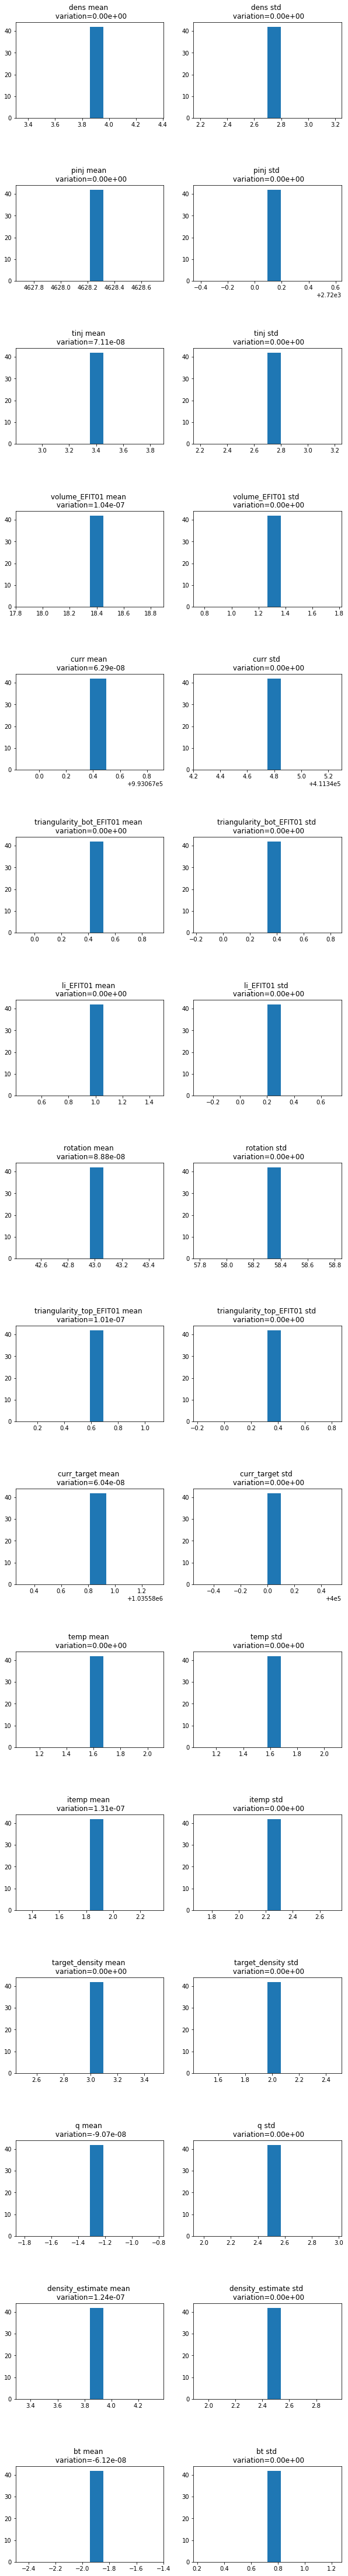

In [49]:
fig, ax = plt.subplots(len(sigs),2,figsize=(10,len(sigs)*5))

meanmeans={}
meanstds={}
for i, sig in enumerate(sigs):
    means = np.array([foo[sig]['median'] for foo in nd])
    stds = np.array([foo[sig]['iqr'] for foo in nd])
    meanmeans[sig] = np.mean(means)
    meanstds[sig] = np.mean(stds)
    ax[i,0].hist(means)
    ax[i,1].hist(stds)
    ax[i,0].set_title(sig+ ' mean \n variation={:.2e}'.format(np.std(means)/np.mean(means)))
    ax[i,1].set_title(sig+ ' std \n variation={:.2e}'.format(np.std(stds)/np.mean(stds)))
plt.subplots_adjust(hspace=0.7)

In [42]:
full_data_oath = '/scratch/gpfs/jabbate/full_data/train_data_full.pkl'
test_data_path = '/scratch/gpfs/jabbate/full_data/test_data.pkl' 
traindata, valdata, normalization_dict = process_data(test_data_path,
                                                      scenario['sig_names'],
                                                      scenario['normalization_method'],
                                                      scenario['window_length'],
                                                      scenario['window_overlap'],
                                                      scenario['lookbacks'],
                                                      scenario['lookahead'],
                                                      scenario['sample_step'],
                                                      scenario['uniform_normalization'],
                                                      1, #scenario['train_frac'],
                                                      0, #scenario['val_frac'],
                                                      scenario['nshots'],
                                                      2, #scenario['verbose']
                                                      scenario['flattop_only'],
                                                      randomize=False,
                                                      pruning_functions=scenario['pruning_functions'],
                                                      excluded_shots = scenario['excluded_shots'],
                                                      delta_sigs = [])

Loading
Signals: curr_target, dens, density_estimate, itemp, li_EFIT01, pinj, q, rotation, target_density, temp, tinj, triangularity_bot_EFIT01, triangularity_top_EFIT01, volume_EFIT01
Number of useable shots:  461
Number of shots used:  461
Total number of timesteps:  53961
Shots with Complete NaN: 
38330 samples total
Removing ECH
Removed 19151 samples
19179 samples remaining
Removing timesteps WITHOUT gas feedback
Removed 2570 samples
16609 samples remaining
Removing weird I-coils
Removed 4980 samples
11629 samples remaining
Removing NaN
Removed 0 samples
11629 samples remaining
Removing dudtrip
Removed 402 samples
11227 samples remaining
11227 samples remaining after pruning
Total number of samples:  11227
Number of training samples:  11227
Number of validation samples:  0


In [50]:
for sig in sigs:
    try:
        testmean = normalization_dict[sig]['median']
        trainmean = meanmeans[sig]
        print(sig + '  mean % err: ' + str((testmean-trainmean)/trainmean))
        teststd = normalization_dict[sig]['iqr']
        trainstd = meanstds[sig]
        print(sig + '  std % err: ' + str((teststd-trainstd)/trainstd))
    except:
        print('no sig {}'.format(sig))

dens  mean % err: 0.033074494
dens  std % err: -0.35934788028041004
pinj  mean % err: 0.34200382
pinj  std % err: 0.2927199691603603
tinj  mean % err: 0.48227462
tinj  std % err: 0.07782320271657339
volume_EFIT01  mean % err: -0.02346043
volume_EFIT01  std % err: -0.06171034228305414
curr  mean % err: -0.08747077
curr  std % err: -0.3773660962003283
triangularity_bot_EFIT01  mean % err: 0.6838879
triangularity_bot_EFIT01  std % err: -0.32039181358485413
li_EFIT01  mean % err: -0.008408744
li_EFIT01  std % err: 0.4737691800892701
rotation  mean % err: 0.19929315
rotation  std % err: -0.0403713387429131
triangularity_top_EFIT01  mean % err: -0.38380727
triangularity_top_EFIT01  std % err: -0.10072107819382912
curr_target  mean % err: -0.13076298
curr_target  std % err: -0.29590234375
temp  mean % err: -0.05332279
temp  std % err: -0.0020565146666514733
itemp  mean % err: -0.008109505
itemp  std % err: -0.10755474957007127
target_density  mean % err: 0.16863403
target_density  std % err: 

In [1]:
path = '/scratch/gpfs/jabbate/old_stuff/new_data/directory.pkl'

In [4]:
with open(path,'rb') as f:
    data = pickle.load(f,encoding='latin1')

In [6]:
data['avail_sigs']

{'ip_flat_duration': 11324,
 't_ip_flat': 11324,
 'topology': 11324,
 'pinj': 11172,
 'tinj': 11172,
 'gasA': 11313,
 'gasB': 11313,
 'gasC': 11313,
 'gasD': 11313,
 'gasE': 11313,
 'curr': 11324,
 'curr_target': 11323,
 'ech': 10476,
 'gas_feedback': 11323,
 'which_gas': 11323,
 'target_density': 11323,
 'density_estimate': 11323,
 'dud_trip': 8231,
 'bt': 11324,
 'C_coil_nonstandard_79': 11324,
 'C_coil_nonstandard_139': 11324,
 'C_coil_nonstandard_199': 11324,
 'I_coil_nonstandard_30': 11324,
 'I_coil_nonstandard_90': 9721,
 'I_coil_nonstandard_150': 9721,
 'C_coil_method': 11324,
 'I_coil_method': 11324,
 'pfx1': 11304,
 'pfx2': 11303,
 'zeff': 10140,
 'C_coil_19': 11260,
 'C_coil_79': 11262,
 'C_coil_139': 11262,
 'C_coil_199': 11262,
 'C_coil_259': 11260,
 'C_coil_319': 11260,
 'I_coil_30U': 11138,
 'I_coil_90U': 11138,
 'I_coil_150U': 11138,
 'I_coil_210U': 11138,
 'I_coil_270U': 11138,
 'I_coil_330U': 11138,
 'I_coil_30L': 11138,
 'I_coil_90L': 11138,
 'I_coil_150L': 11138,
 'I